In [1]:
import typing

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import re

from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.metrics.pairwise import cosine_similarity
import config
import src
import requests
import tqdm
import json
import numpy as np
import logging
import torch
device = torch.device('cpu')
from transformers import AutoTokenizer, AutoModel
#import cltrier_lib as lib

import yaml
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sstolwi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sstolwi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\sstolwi\Github\llmdiv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
 

In [2]:
CFG = config.Config()

In [4]:
dataset: pd.DataFrame = pd.read_csv('data/publicsphere/full_data.csv')
dataset

,StartDate,RecordedDate,IPAddress,Finished,Coder,ID,Mark_ID,Genre,topiccode,Platform,...,dislikeCount_video,likeCount_video,date_difference,commentCount_video,replyCount_comment,topic,subscribers,HATELIST_FOCUSED_DUMMY,Time_comment_year,Time_video_year
0,5/30/2021 13:03:17,5/30/2021 13:04:17,62.194.51.29,1,6,UgyPHwv8G0cDE6-wEgl4AaABAg.8_0ZjJKSJty8_0kXGkAd2U,119,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2017,2017.0
1,10/11/2021 10:34:05,10/11/2021 10:36:46,213.127.109.191,1,6,Ugx2WXq9UdV8mPPjejJ4AaABAg.8yHCKV0Boe58yYRxEQEF45,282,1,2,1,...,195.0,3817.0,743.0,1748.0,NaN,economy,3630000.0,0,2019,2019.0
2,9/9/2021 18:49:48,9/9/2021 18:51:32,213.127.110.0,1,6,1110578710648890000,372,2,4,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2019,NaN
3,6/6/2021 16:12:46,6/6/2021 16:16:16,213.127.76.145,1,6,UgwUPFScjJ0MCeaP2F54AaABAg.8lvp3fc9Euf8lvvgsUgEgV,769,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2018,2018.0
4,6/13/2021 13:25:49,6/13/2021 13:27:28,213.127.82.232,1,6,UgwWKCWtSJdFvjGHvTp4AaABAg.8kUC5dGrQ2H8kUDRihE2f3,1206,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2018,2018.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3857,8/19/2021 14:50:13,8/19/2021 14:54:28,62.194.51.29,1,6,1152219467579100000,10000695,0,4,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2019,NaN
3858,8/19/2021 15:10:27,8/19/2021 15:12:21,62.194.51.29,1,6,1085362296472430000,10007008,1,4,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2019,NaN
3859,10/6/2021 16:08:39,10/6/2021 16:10:42,213.127.113.113,1,6,UghFY3QJ6nmT_ngCoAEC.7-H0Z7--wxd8goqpaPs-bl,20000102,0,3,1,...,2820.0,12475.0,3803.0,4785.0,NaN,east,6740000.0,0,2018,2010.0
3860,10/15/2021 18:30:04,10/15/2021 18:35:40,213.127.109.191,1,6,UgyWabsmmnq3zam4DgZ4AaABAg,20000418,2,3,1,...,118.0,31761.0,1531.0,2206.0,0.0,east,6800000.0,0,2018,2015.0


In [5]:
#first just try pre-processing and a simple tf-ivf:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

In [35]:
def preprocess(texts):
    x_train = []
    for sent in tqdm.tqdm(texts):
        sent = re.sub(r'@[^ ]+', '', sent)  #remove all usernames
        sent = re.sub(r'https?://[^ ]+', '', sent) #remove all hyperlinks
        sent = re.sub(r'#', '', sent) #remove all hashtags
        sent = re.sub(r'([A-Za-z])\1{2,}', r'\1', sent) #normalize language use by replacing duplicate letters by single letters
        sent = re.sub("[^a-zA-Z ]", "", sent) #remove all non-words
        sent = sent.lower().split()
        sent = [lemmatizer.lemmatize(word) for word in sent if word not in set(stop_words)]
        sent = ' '.join(sent)
        x_train.append(sent)
    return x_train

In [36]:
X = preprocess(dataset["commentText"])

100%|██████████| 3862/3862 [00:05<00:00, 654.85it/s] 


In [37]:
tfidf = TfidfVectorizer(max_features=5000, analyzer='word', ngram_range=(1,2), stop_words='english')
X_tfidf = tfidf.fit_transform(X).toarray()

In [12]:
X_tfidf[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [73]:
dataset['tfidf_embedding'] = [torch.tensor(X_tfidf[i], dtype=torch.float32).flatten().tolist() for i in range(X_tfidf.shape[0])]


In [ ]:
dataset['tfidf_embedding']

In [38]:
cosine_similarities = cosine_similarity(X_tfidf)
cosine_similarities

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.0110684 , 0.06654491,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.08009685, 0.        ,
        0.        ],
       ...,
       [0.        , 0.0110684 , 0.08009685, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.06654491, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [54]:
num_documents = len(cosine_similarities)

# Initialize a list to store the most similar document pairs
top_similar_pairs = []

# Iterate through all document pairs
for i in range(num_documents):
    for j in range(i + 1, num_documents):
        similarity = cosine_similarities[i][j]
        
        # Check if the similarity is NaN or zero
        if not np.isnan(similarity) and similarity >= 1:
            pair = (i, j)
            top_similar_pairs.append((similarity, pair))
            
# Sort the list based on similarity in descending order
top_similar_pairs.sort(key=lambda x: x[0], reverse=True)
            


In [ ]:
top_similar_pairs

In [55]:
result = [pair for value, pair in top_similar_pairs if value >= 1]
print(result)

[(139, 1990), (246, 1179), (362, 736), (722, 739), (21, 1856), (75, 366), (75, 1022), (75, 2122), (75, 2421), (75, 2946), (101, 850), (133, 1057), (141, 3838), (164, 1240), (164, 2182), (198, 3213), (242, 2779), (242, 3278), (259, 490), (313, 2607), (341, 352), (366, 1022), (366, 2122), (366, 2421), (366, 2946), (395, 3340), (400, 585), (400, 877), (400, 962), (400, 2099), (400, 2848), (400, 3752), (436, 3211), (487, 936), (487, 2484), (546, 911), (559, 3708), (585, 877), (585, 962), (585, 2099), (585, 2848), (585, 3752), (643, 1401), (673, 1743), (678, 2244), (678, 2481), (678, 2843), (678, 2856), (678, 2971), (702, 1392), (709, 1800), (753, 930), (753, 1564), (753, 1887), (753, 2728), (793, 2935), (813, 1872), (816, 1088), (877, 962), (877, 2099), (877, 2848), (877, 3752), (894, 1060), (914, 2707), (914, 2914), (919, 3578), (930, 1564), (930, 1887), (930, 2728), (936, 2484), (937, 1005), (937, 1192), (955, 1404), (962, 2099), (962, 2848), (962, 3752), (969, 1196), (969, 1449), (969, 

In [ ]:
for first, second in result:
    print(dataset["commentText"][[first, second]])
    print()

In [61]:
print(X[246])
print(X[1179])
print(X[139])
print(X[1990])
print(X[21])
print(X[1856])
print(X[722])
print(X[739])
print(X[362])
print(X[736])

hell yeah fam
hell yeah
vote trump
vote trump
mika low iq
still low iq
good grief
opinionlol good grief
persinger apple orange
apple orange


In [74]:
grouped_data = dataset.groupby("Platform")
dist = torch.nn.PairwiseDistance()
resultsplatform: typing.Dict[typing.Tuple[str, str], float] = {}
for model_1, c_1 in tqdm.tqdm(grouped_data['tfidf_embedding'], total=grouped_data.ngroups):
    for model_2, c_2 in tqdm.tqdm(grouped_data['tfidf_embedding'], total=grouped_data.ngroups):

        if (
            (model_1, model_2) in resultsplatform.keys() or 
            (model_2, model_1) in resultsplatform.keys()
        ):
            continue

        res = sum([
            sum(dist(
                torch.tensor(np.array(v_1)), 
                torch.tensor(np.array(c_2.tolist()))
                )) / len(c_2)
            for v_1 in c_1
        ]) / len(c_1)

        resultsplatform[(model_1, model_2)] = res

        print(f'{model_1}:{model_2}:{res.item()}')

KeyboardInterrupt: 

In [ ]:
grouped_data = dataset.groupby("topiccode")
dist = torch.nn.PairwiseDistance()
resultstopic: typing.Dict[typing.Tuple[str, str], float] = {}
for model_1, c_1 in tqdm.tqdm(grouped_data['tfidf_embedding'], total=grouped_data.ngroups):
    for model_2, c_2 in tqdm.tqdm(grouped_data['tfidf_embedding'], total=grouped_data.ngroups):

        if (
            (model_1, model_2) in resultstopic.keys() or 
            (model_2, model_1) in resultstopic.keys()
        ):
            continue

        res = sum([
            sum(dist(
                torch.tensor(np.array(v_1)), 
                torch.tensor(np.array(c_2.tolist()))
                )) / len(c_2)
            for v_1 in c_1
        ]) / len(c_1)

        resultstopic[(model_1, model_2)] = res

        print(f'{model_1}:{model_2}:{res.item()}')

In [ ]:
grouped_data = dataset.groupby("Genre")
dist = torch.nn.PairwiseDistance()
resultsgenre: typing.Dict[typing.Tuple[str, str], float] = {}
for model_1, c_1 in tqdm.tqdm(grouped_data['tfidf_embedding'], total=grouped_data.ngroups):
    for model_2, c_2 in tqdm.tqdm(grouped_data['tfidf_embedding'], total=grouped_data.ngroups):

        if (
            (model_1, model_2) in resultsgenre.keys() or 
            (model_2, model_1) in resultsgenre.keys()
        ):
            continue

        res = sum([
            sum(dist(
                torch.tensor(np.array(v_1)), 
                torch.tensor(np.array(c_2.tolist()))
                )) / len(c_2)
            for v_1 in c_1
        ]) / len(c_1)

        resultsgenre[(model_1, model_2)] = res

        print(f'{model_1}:{model_2}:{res.item()}')

In [3]:
MODEL: str = 'llama3.1:8b-instruct-q6_K' # options: 'gemma:7b-instruct-q6_K', 'gemma2:27b-instruct-q6_K', 'llama3.1:8b-instruct-q6_K', 'llama3.1:70b-instruct-q6_K', 'mistral:7b-instruct-v0.3-q6_K', 'mistral-large:123b-instruct-2407-q6_K', 'mixtral:8x7b-instruct-v0.1-q6_K', 'mixtral:8x22b-instruct-v0.1-q6_K', 'phi3:14b-medium-128k-instruct-q6_K' or 'qwen2:72b-instruct-q6_K'


In [5]:
embed_MXBAI: typing.Dict[str, np.ndarray] = {}

In [10]:
context = 'social media replies to a news- or infotainment-post'
for index, row in tqdm.tqdm(dataset["commentText"].items(), total=len(dataset)):
    try: 
        embed = np.array(requests.post(
            'https://inf.cl.uni-trier.de/embed/',
            json={'model': MODEL, 
                  'prompt': 'You help me get embeddings for a sentence. I provide you with a context and a sentence and you reply only with that exact sentence. Context = ' + context + '; Sentence: ' + row}
            ).json()["response"])
    except Exception as _e:
        logging.warning(_e)
        embed = None
    
    embed_MXBAI[index] = embed

  3%|▎         | 123/3862 [04:58<2:31:24,  2.43s/it]


KeyboardInterrupt: 

In [ ]:
dataset_w_embeds = dataset.join(pd.Series(embed_MXBAI, name="embed_MXBAI"))
dataset_w_embeds.to_parquet(f'{CFG.report_dir}/pubsphere.MXBAIembeds.parquet')
dataset_w_embeds.head()

In [6]:
#load datasets:
dataset_w_embeds = pd.read_parquet(f'{CFG.report_dir}/pubsphere.MXBAIembeds.parquet')
#dataset_prompt = pd.read_parquet(f'{CFG.report_dir}\publicsphere.cardiff_prompt_classify_s.parquet')
dataset_claim_embeds = pd.read_parquet(f'{CFG.report_dir}/pubsphere.claim_embed.parquet')



In [ ]:
#create BERT-base embeddings for each word:

model_name = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [ ]:
#create Twhin-BERT-base embeddings for each word:
model_name = "Twitter/twhin-bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [12]:
#calculate DiffCSE embeddings:
model_name = "voidism/diffcse-roberta-base-sts"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

/Users/SjoerdStolwijk/anaconda3/envs/DefiningDebateQuality/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at voidism/diffcse-roberta-base-sts were not used when initializing RobertaModel: ['aux_bert.embeddings.LayerNorm.bias', 'aux_bert.embeddings.LayerNorm.weight', 'aux_bert.embeddings.position_embeddings.weight', 'aux_bert.embeddings.position_ids', 'aux_bert.embeddings.token_type_embeddings.weight', 'aux_bert.embeddings.word_embeddings.weight', 'aux_bert.encoder.layer.0.attention.output.LayerNorm.bias', 'aux_bert.encoder.layer.0.attention.output.LayerNorm.weight', 'aux_bert.encoder.layer.0.attention.output.dense.bias', 'aux_bert.encoder.layer.0.attention.output.dense.weight', 'aux_bert.encoder.layer.0.attention.self.key.bias'

In [13]:
#function for encoding sentence embeddings based on the DiffCSE approach which is based on (and refers to) SimCSE/evaluation.py 
def encode_sentence(sentence):
    input_ids = tokenizer.encode(sentence, add_special_tokens=True, truncation=True, max_length=512, padding='max_length')
    input_ids_tensor = torch.tensor(input_ids).unsqueeze(0)  # Add batch dimension
    attention_mask = torch.ones_like(input_ids_tensor)  # Creating attention mask 
    with torch.no_grad():
            outputs = model(input_ids_tensor, output_hidden_states=True, return_dict=True, attention_mask=attention_mask)
            sentence_embedding = outputs.last_hidden_state[:, 0].cpu()
            return sentence_embedding.tolist()

In [ ]:
#for DiffCSE: Create embeddings for each argument and store them in a new column
dataset.loc[:, 'DiffCSE_embedding'] = dataset["commentText"].apply(encode_sentence)

In [7]:
#claim mine the publicsphere data
#first add system prompt


In [5]:
SYSTEM_claim: str = \
    """
        Instruction:

        You are a text annotation assitant. Analyze a collection of social media comments enclosed in chevrons <..>. Identify and list the claims within these comments. Claims can be related to events, issues, opinions or concerns in relation to the specified topic.
        Claims are defined as the main assertion or conclusion of an argument.
        You summarize each claim into a short simple sentence.

        Response format:

        You provide only the list of claims, separated by commas, without any additional text or explanations. If no claims can be identified, return an empty list [].

        Response format template:
        
        ["claim 1", "claim 2", ... "claim x"]
	"""

In [6]:
MODEL: str = 'llama3.1:70b-instruct-q6_K'  # options: 'gemma:7b-instruct-q6_K', 'gemma2:27b-instruct-q6_K', 'llama3.1:8b-instruct-q6_K', 'llama3.1:70b-instruct-q6_K', 'mistral:7b-instruct-v0.3-q6_K', 'mistral-large:123b-instruct-2407-q6_K', 'mixtral:8x7b-instruct-v0.1-q6_K', 'mixtral:8x22b-instruct-v0.1-q6_K', 'phi3:14b-medium-128k-instruct-q6_K' or 'qwen2:72b-instruct-q6_K'


In [9]:
dataset_w_embeds.columns

Index(['StartDate', 'RecordedDate', 'IPAddress', 'Finished', 'Coder', 'ID',
       'Mark_ID', 'Genre', 'topiccode', 'Platform', 'Anonymity',
       'Anonymity_9_TEXT', 'codable', 'Interaction', 'Acknowledgement',
       'TopicRelevance', 'Reasoning', 'BackgroundInfo', 'ExternalEvidence',
       'ExternalEvidence_1_TEXT', 'Opinion', 'disagreement',
       'Ideologicaldirection', 'Name_calling', 'Vulgarity',
       'Attack_reputation', 'Question_Intelligenc', 'All_caps_function',
       'Sarcasm_to_criticize', 'Individual_right', 'discrimination',
       'Invoke_violence', 'Tone', 'INTERACTIVITY_DUMMY', 'RATIONALITY_DUMMY',
       'HAS_OPINION_DUMMY', 'LIBERAL_NEUTRAL_CONSERVATIVE', 'LIBERAL_DUMMY',
       'CONSERVATIVE_DUMMY', 'NAMECALLING_DUMMY', 'VULGAR_DUMMY',
       'NAMECALLING_VULGAR_DUMMY', 'INCIVILITY_ORDINAL', 'INCIVILITY_DUMMY',
       'INTOLERANCE_DUMMY', 'filter_$', 'IMPOLITENESS_DUMMY', 'commentText',
       'showName', 'genre', 'Time_comment', 'likeCount_comment', 'entitie

topiccode staat voor:
0 : YouTube general
1 : YT Mueller/Comy investigation
2 : YT: Economy
3 : YT: Middle East
4 : Twitter:general

In [10]:
topicdict = {0 : 'YTgen', 
1 : 'YT_investigation',
2 : 'YT_Econ',
3 : 'YT_ME',
4 : 'Twitgen'}

dataset_w_embeds.loc[:,'topiccodeSTR']= dataset_w_embeds.topiccode.map(topicdict)

In [ ]:
#dataset_prompt.loc[:,'topiccodeSTR']= dataset_prompt.topiccode.map(topicdict)

In [12]:
options_str = """
seed: 42
temperature: 0.8
num_predict: 128
"""

options = yaml.safe_load(options_str)

In [13]:

requests.post(
                            'https://inf.cl.uni-trier.de/',
                            json={
                                'model': MODEL,
                                'system': SYSTEM_claim,
                                'prompt': f'The following set of social media posts are replies to a news- or infotainment-post. '
                                        + f'Check whether your answer only consists of a list of claims. \n"Posts":\n<{dataset_w_embeds["commentText"][:5].to_list()}>',
                                'options': options_low
                                }).json()

{'id': 'f1348f82-7a48-11ef-8a91-0d8e6fdd3d4b',
 'timestamp': '2024-09-24T07:45:17.476415',
 'model': 'llama3.1:70b-instruct-q6_K',
 'prompt': [{'role': 'system',
   'content': '\n        Instruction:\n\n        You are a text annotation assitant. Analyze a collection of social media comments enclosed in chevrons <..>. Identify and list the claims within these comments. Claims can be related to events, issues, opinions or concerns in relation to the specified topic.\n        Claims are defined as the main assertion or conclusion of an argument.\n        You summarize each claim into a short simple sentence.\n\n        Response format:\n\n        You provide only the list of claims, separated by commas, without any additional text or explanations. If no claims can be identified, return an empty list [].\n\n        Response format template:\n        \n        ["claim 1", "claim 2", ... "claim x"]\n\t'},
  {'role': 'user',
   'content': 'The following set of social media posts are replies 

In [52]:
#get a list of claims per comment:
chunked_result: typing.List[pd.DataFrame] = []
for index, row in tqdm.tqdm(dataset_prompt.iterrows()):
    try: 
        chunked_result.append(
            pd.DataFrame(
                data=[
                    requests.post(
                        'https://inf.cl.uni-trier.de/',
                        json={
                            'model': MODEL,
                            'system': SYSTEM_claim,
                            'prompt': f'The following set of social media posts are replies to a news- or infotainment-post. '
                                    + f'Check whether your answer strictly adheres to the specified format. \n"Posts":\n<{row["commentText"]}>',
                            'options': options
                            }).json()['response']                       
                ],
                columns=['claims']
            )
        )
        
    except json.JSONDecodeError:
        print("invalid json response, skipping to next batch")

3862it [2:05:28,  1.95s/it]


In [27]:
#apply generalized claim mining to get a list of claims:
chunked_result: typing.List[pd.DataFrame] = []
for label, group in dataset_prompt[:5].groupby('topiccodeSTR'):
    for index, row in tqdm.tqdm(group.iterrows()):
        try: 
            chunked_result.append(
                pd.DataFrame(
                    data=[
                        requests.post(
                            'https://inf.cl.uni-trier.de/',
                            json={
                                'model': MODEL,
                                'system': SYSTEM_claim,
                                'prompt': f'The following set of social media posts are replies to a news- or infotainment-post. '
                                        + f'Check whether your answer strictly adheres to the specified format. \n"Posts":\n<{row["commentText"]}>'
                                }).json()['response']                       
                    ],
                    columns=['claims']
                )
                .assign(label=label)
            )
            
        except json.JSONDecodeError:
            print("invalid json response, skipping to next batch")

0it [00:00, ?it/s]

1it [00:16, 16.55s/it]
1it [00:02,  2.04s/it]
3it [00:04,  1.40s/it]


In [54]:
claim_df = pd.concat(chunked_result, ignore_index=True)
print(claim_df)

                                                 claims
0                                                    []
1     ["Minerals have rights too", "A box of rocks w...
2     ["There is a question about whether Trump was ...
3     ["The death of free and civil dialogue is evid...
4                         ["Nobody else will hug him."]
...                                                 ...
3857  ["They can't afford chemical peels and facelif...
3858                           ["He will be confirmed"]
3859  ["They knew all about the cameras.", "The susp...
3860  ["Troops are waiting in the fields", "Men will...
3861  ["Russia and the US are both against ISIS", "T...

[3862 rows x 1 columns]


In [ ]:
claim_df.claims.to_list()

In [49]:
dataset_prompt.claim_run1[:960].tail()

955                                                   []
956    ["Democrats support Dan in 2020", "Someone nam...
957    ["There is a recording that has not been relea...
958                                  ["He had dementia"]
959    ["Only Red States are prone to natural disaste...
Name: claim_run1, dtype: object

In [16]:
dataset_claim = pd.read_parquet(f'{CFG.report_dir}/pubsphere.claim.parquet')


In [4]:
#change options to low temperature (0,1) and compare result:
options_low = """
seed: 42
temperature: 0.1
"""

options_low = yaml.safe_load(options_low)

In [41]:
requests.post(
                            'https://inf.cl.uni-trier.de/',
                            json={
                                'model': MODEL,
                                'system': SYSTEM_claim,
                                'prompt': f'The following set of social media posts are replies to a news- or infotainment-post. '
                                        + f'Check whether your answer only consists of a list of claims. \n"Posts":\n<{dataset_claim["commentText"][:5].to_list()}>',
                                'options': options_low
                                }).json()

{'id': 'eba29042-7a60-11ef-8a91-0d8e6fdd3d4b',
 'timestamp': '2024-09-24T10:36:56.052522',
 'model': 'llama3.1:70b-instruct-q6_K',
 'prompt': [{'role': 'system',
   'content': '\n        Instruction:\n\n        You are a text annotation assitant. Analyze a collection of social media comments enclosed in chevrons <..>. Identify and list the claims within these comments. Claims can be related to events, issues, opinions or concerns in relation to the specified topic.\n        Claims are defined as the main assertion or conclusion of an argument.\n        You summarize each claim into a short simple sentence.\n\n        Response format:\n\n        You provide only the list of claims, separated by commas, without any additional text or explanations. If no claims can be identified, return an empty list [].\n\n        Response format template:\n        \n        ["claim 1", "claim 2", ... "claim x"]\n\t'},
  {'role': 'user',
   'content': 'The following set of social media posts are replies 

In [50]:
#test low temperature claims per comment:
chunked_result: typing.List[pd.DataFrame] = []
for index, row in tqdm.tqdm(dataset_claim.iterrows()):
    try: 
        chunked_result.append(
            pd.DataFrame(
                data=[
                    requests.post(
                        'https://inf.cl.uni-trier.de/',
                        json={
                            'model': MODEL,
                            'system': SYSTEM_claim,
                            'prompt': f'The following set of social media posts are replies to a news- or infotainment-post. '
                                    + f'Check whether your answer strictly adheres to the specified format. \n"Posts":\n<{row["commentText"]}>',
                            'options': options_low
                            }).json()['response']                       
                ],
                columns=['claims']
            )
        )
        
    except json.JSONDecodeError:
        print("invalid json response, skipping to next batch")

3862it [2:00:19,  1.87s/it]


In [51]:
chunked_result[:5]

[  claims
 0     [],
                           claims
 0  ["Minerals have rights too."],
                                               claims
 0  ["The question has always been if Trump was co...,
                                               claims
 0  ["There are only a few people left who value f...,
                     claims
 0  ["No one will hug him"]]

In [52]:
claim_low = pd.concat(chunked_result, ignore_index=True)
print(claim_low)

                                                 claims
0                                                    []
1                         ["Minerals have rights too."]
2     ["The question has always been if Trump was co...
3     ["There are only a few people left who value f...
4                               ["No one will hug him"]
...                                                 ...
3857  ["Some women cannot afford beauty treatments w...
3858                           ["He will be confirmed"]
3859  ["The individuals in question knew about the c...
3860  ["Troops are waiting in the fields", "Joining ...
3861  ["The Syrian crisis has strange components", "...

[3862 rows x 1 columns]


In [53]:
#list the claims in a way that links them to the original post, so we can group the claims according to any grouper, while still being able to find unique embeddings per claim: 
claim_df = claim_low
claim_df['original_index'] = claim_df.index
claim_df['claims'] = claim_df['claims'].str.split('",')
claim_df = claim_df.explode('claims')
claim_df = claim_df.reset_index(drop=True)
claim_df = claim_df.drop_duplicates()
print(claim_df)

                                                 claims  original_index
0                                                    []               0
1                                ["Minerals have rights               1
2      "The post is a vicious insult to boxes of roc...               1
3                     ["Trump may have been compromised               2
4      "The extent of Trump's awareness about his ow...               2
...                                                 ...             ...
1408                    ["Democrats support Dan in 2020             956
1409          "Someone named Mica should be destroyed"]             956
1410  ["There is a recording that has not been relea...             957
1411                                ["He had dementia"]             958
1412  ["Only Red States are prone to natural disaste...             959

[1413 rows x 2 columns]


In [66]:
dataset_claim_embeds.loc[:, "claim_optlow"]=claim_low

In [29]:
dataset_claim_embeds.to_parquet(f'{CFG.report_dir}/pubsphere.claim_embed.parquet')

In [75]:
#get MXBAI embeddings for the claims:
context = 'claims made in social media replies to a news- or infotainment-post'
claim_optlow_MXBAI: typing.Dict[str, np.ndarray] = (
    pd.Series(src.SentenceEmbedder()(dataset_claim_embeds["claim_optlow"], prefix= 'You help me get embeddings for a sentence. I provide you with a context and a sentence and you reply only with that exact sentence. Context = ' + context + '; Sentence: '), name="claim_optlow_MXBAI")
    .rename_axis(index=dataset_claim_embeds.index.names)
)
claim_optlow_MXBAI

100%|██████████| 3862/3862 [13:49<00:00,  4.66it/s]


0       [0.3085225224494934, 0.0025453902781009674, -0...
1       [0.34888750314712524, -0.01314709335565567, -0...
2       [0.4851573407649994, -0.06400042772293091, -0....
3       [0.31287914514541626, -0.15600241720676422, -0...
4       [0.5331375598907471, -0.04385572671890259, -0....
                              ...                        
3857    [0.2503626346588135, -0.3144466280937195, -0.7...
3858    [0.5046452283859253, -0.13685280084609985, -0....
3859    [0.6014363765716553, -0.26543501019477844, -0....
3860    [0.43446165323257446, -0.1825677752494812, -0....
3861    [0.3531288206577301, -0.019186511635780334, -0...
Name: claim_optlow_MXBAI, Length: 3862, dtype: object

In [3]:
dataset_claim_embeds = pd.read_parquet(f'{CFG.report_dir}/pubsphere.claim_embed.parquet')

In [7]:
dataset_claim_embeds.head()

,StartDate,RecordedDate,IPAddress,Finished,Coder,ID,Mark_ID,Genre,topiccode,Platform,...,irony,hate,topiccodeSTR,claim_run1,claim_optdef,claim_optdef_embed_MXBAI,claim_optlow,claim_optlow_MXBAI,tfidf_embed_post,embed_MXBAI_post
0,5/30/2021 13:03:17,5/30/2021 13:04:17,62.194.51.29,1,6,UgyPHwv8G0cDE6-wEgl4AaABAg.8_0ZjJKSJty8_0kXGkAd2U,119,0,0,1,...,"{'non_irony', 'irony'}",{'NOT-HATE'},YTgen,[],[],"[0.3085225224494934, 0.0025453902781009674, -0...",[],"[0.3085225224494934, 0.0025453902781009674, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.40566757321357727, -0.032418690621852875, -..."
1,10/11/2021 10:34:05,10/11/2021 10:36:46,213.127.109.191,1,6,Ugx2WXq9UdV8mPPjejJ4AaABAg.8yHCKV0Boe58yYRxEQEF45,282,1,2,1,...,{'non_irony'},{'NOT-HATE'},YT_Econ,"[""Minerals have rights"", ""The post is a viciou...","[""Minerals have rights too"", ""A box of rocks w...","[0.3428829610347748, 0.03502892702817917, -0.5...","[""Minerals have rights too.""]","[0.34888750314712524, -0.01314709335565567, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.49942252039909363, -0.22240903973579407, -0..."
2,9/9/2021 18:49:48,9/9/2021 18:51:32,213.127.110.0,1,6,1110578710648890000,372,2,4,2,...,{'non_irony'},{'NOT-HATE'},Twitgen,"[""Trump may have been compromised"", ""The exten...","[""There is a question about whether Trump was ...","[0.5012139081954956, -0.1079118549823761, -0.6...","[""The question has always been if Trump was co...","[0.4851573407649994, -0.06400042772293091, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.6132397651672363, -0.3024018704891205, -0.6..."
3,6/6/2021 16:12:46,6/6/2021 16:16:16,213.127.76.145,1,6,UgwUPFScjJ0MCeaP2F54AaABAg.8lvp3fc9Euf8lvvgsUgEgV,769,0,0,1,...,{'irony'},{'NOT-HATE'},YTgen,"[""There are only a few people left who value c...","[""The death of free and civil dialogue is evid...","[0.21832342445850372, -0.13364076614379883, -0...","[""There are only a few people left who value f...","[0.31287914514541626, -0.15600241720676422, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.27884048223495483, -0.3008716404438019, -0...."
4,6/13/2021 13:25:49,6/13/2021 13:27:28,213.127.82.232,1,6,UgwWKCWtSJdFvjGHvTp4AaABAg.8kUC5dGrQ2H8kUDRihE2f3,1206,0,0,1,...,"{'non_irony', 'irony'}",{'NOT-HATE'},YTgen,"[""Nobody wants to hug him""]","[""Nobody else will hug him.""]","[0.49281346797943115, -0.11275702714920044, -0...","[""No one will hug him""]","[0.5331375598907471, -0.04385572671890259, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.5210463404655457, 0.03200243413448334, -0.3..."


In [89]:
#dataset_claim_embeds = dataset_claim_embeds.join(claim_optlow_MXBAI)
dataset_claim_embeds.to_parquet(f'{CFG.report_dir}/pubsphere.claim_embed.parquet')
dataset_claim_embeds.head()

,StartDate,RecordedDate,IPAddress,Finished,Coder,ID,Mark_ID,Genre,topiccode,Platform,...,irony,hate,topiccodeSTR,claim_run1,claim_optdef,claim_optdef_embed_MXBAI,claim_optlow,claim_optlow_MXBAI,tfidf_embed_post,embed_MXBAI_post
0,5/30/2021 13:03:17,5/30/2021 13:04:17,62.194.51.29,1,6,UgyPHwv8G0cDE6-wEgl4AaABAg.8_0ZjJKSJty8_0kXGkAd2U,119,0,0,1,...,"{'non_irony', 'irony'}",{'NOT-HATE'},YTgen,[],[],"[0.3085225224494934, 0.0025453902781009674, -0...",[],"[0.3085225224494934, 0.0025453902781009674, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.40566757321357727, -0.032418690621852875, -..."
1,10/11/2021 10:34:05,10/11/2021 10:36:46,213.127.109.191,1,6,Ugx2WXq9UdV8mPPjejJ4AaABAg.8yHCKV0Boe58yYRxEQEF45,282,1,2,1,...,{'non_irony'},{'NOT-HATE'},YT_Econ,"[""Minerals have rights"", ""The post is a viciou...","[""Minerals have rights too"", ""A box of rocks w...","[0.3428829610347748, 0.03502892702817917, -0.5...","[""Minerals have rights too.""]","[0.34888750314712524, -0.01314709335565567, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.49942252039909363, -0.22240903973579407, -0..."
2,9/9/2021 18:49:48,9/9/2021 18:51:32,213.127.110.0,1,6,1110578710648890000,372,2,4,2,...,{'non_irony'},{'NOT-HATE'},Twitgen,"[""Trump may have been compromised"", ""The exten...","[""There is a question about whether Trump was ...","[0.5012139081954956, -0.1079118549823761, -0.6...","[""The question has always been if Trump was co...","[0.4851573407649994, -0.06400042772293091, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.6132397651672363, -0.3024018704891205, -0.6..."
3,6/6/2021 16:12:46,6/6/2021 16:16:16,213.127.76.145,1,6,UgwUPFScjJ0MCeaP2F54AaABAg.8lvp3fc9Euf8lvvgsUgEgV,769,0,0,1,...,{'irony'},{'NOT-HATE'},YTgen,"[""There are only a few people left who value c...","[""The death of free and civil dialogue is evid...","[0.21832342445850372, -0.13364076614379883, -0...","[""There are only a few people left who value f...","[0.31287914514541626, -0.15600241720676422, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.27884048223495483, -0.3008716404438019, -0...."
4,6/13/2021 13:25:49,6/13/2021 13:27:28,213.127.82.232,1,6,UgwWKCWtSJdFvjGHvTp4AaABAg.8kUC5dGrQ2H8kUDRihE2f3,1206,0,0,1,...,"{'non_irony', 'irony'}",{'NOT-HATE'},YTgen,"[""Nobody wants to hug him""]","[""Nobody else will hug him.""]","[0.49281346797943115, -0.11275702714920044, -0...","[""No one will hug him""]","[0.5331375598907471, -0.04385572671890259, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.5210463404655457, 0.03200243413448334, -0.3..."


In [90]:
grouped_data = dataset_claim_embeds.groupby("Platform")
dist = torch.nn.PairwiseDistance()
resultstopic: typing.Dict[typing.Tuple[str, str], float] = {}
for model_1, c_1 in tqdm.tqdm(grouped_data['claim_optlow_MXBAI'], total=grouped_data.ngroups):
    for model_2, c_2 in tqdm.tqdm(grouped_data['claim_optdef_embed_MXBAI'], total=grouped_data.ngroups):

        if (
            (model_1, model_2) in resultstopic.keys() or 
            (model_2, model_1) in resultstopic.keys()
        ):
            continue

        res = sum([
            sum(dist(
                torch.tensor(np.array(v_1)), 
                torch.tensor(np.array(c_2.tolist()))
                )) / len(c_2)
            for v_1 in c_1
        ]) / len(c_1)

        resultstopic[(model_1, model_2)] = res

        print(f'{model_1}:{model_2}:{res.item()}')

 50%|█████     | 1/2 [01:05<01:05, 65.16s/it]

1:1:6.125518614334823



 50%|█████     | 1/2 [01:20<01:20, 80.95s/it]

1:2:5.835719833714432



100%|██████████| 2/2 [01:24<00:00, 42.31s/it]

2:2:5.4614455199460945


In [91]:
grouped_data = dataset_claim_embeds.groupby("topiccode")
dist = torch.nn.PairwiseDistance()
resultstopic: typing.Dict[typing.Tuple[str, str], float] = {}
for model_1, c_1 in tqdm.tqdm(grouped_data['claim_optlow_MXBAI'], total=grouped_data.ngroups):
    for model_2, c_2 in tqdm.tqdm(grouped_data['claim_optdef_embed_MXBAI'], total=grouped_data.ngroups):

        if (
            (model_1, model_2) in resultstopic.keys() or 
            (model_2, model_1) in resultstopic.keys()
        ):
            continue

        res = sum([
            sum(dist(
                torch.tensor(np.array(v_1)), 
                torch.tensor(np.array(c_2.tolist()))
                )) / len(c_2)
            for v_1 in c_1
        ]) / len(c_1)

        resultstopic[(model_1, model_2)] = res

        print(f'{model_1}:{model_2}:{res.item()}')

 20%|██        | 1/5 [00:03<00:12,  3.00s/it]

0:0:5.831282414579743



 40%|████      | 2/5 [00:06<00:10,  3.57s/it]

0:1:5.920362972968086



 60%|██████    | 3/5 [00:10<00:07,  3.77s/it]

0:2:6.015851318005866



 80%|████████  | 4/5 [00:14<00:03,  3.83s/it]

0:3:6.222147868105969



 20%|██        | 1/5 [00:18<01:13, 18.26s/it]

0:4:5.659812135038041



 40%|████      | 2/5 [00:04<00:07,  2.44s/it]

1:1:5.8479445110207



 60%|██████    | 3/5 [00:09<00:06,  3.34s/it]

1:2:6.095491385661948



 80%|████████  | 4/5 [00:14<00:04,  4.03s/it]

1:3:6.264403699945341



 40%|████      | 2/5 [00:37<00:56, 18.70s/it]

1:4:5.773747895813895



 60%|██████    | 3/5 [00:04<00:03,  1.55s/it]

2:2:6.129187475207363



 80%|████████  | 4/5 [00:09<00:02,  2.51s/it]

2:3:6.3361580320710065



 60%|██████    | 3/5 [00:50<00:32, 16.14s/it]

2:4:5.815060098598764



 80%|████████  | 4/5 [00:04<00:01,  1.22s/it]

3:3:6.409761093320357



 80%|████████  | 4/5 [00:59<00:13, 13.30s/it]

3:4:6.062728173199805



100%|██████████| 5/5 [01:02<00:00, 12.58s/it]

4:4:5.4614455199460945


In [92]:
grouped_data = dataset_claim_embeds.groupby("Genre")
dist = torch.nn.PairwiseDistance()
resultstopic: typing.Dict[typing.Tuple[str, str], float] = {}
for model_1, c_1 in tqdm.tqdm(grouped_data['claim_optlow_MXBAI'], total=grouped_data.ngroups):
    for model_2, c_2 in tqdm.tqdm(grouped_data['claim_optdef_embed_MXBAI'], total=grouped_data.ngroups):

        if (
            (model_1, model_2) in resultstopic.keys() or 
            (model_2, model_1) in resultstopic.keys()
        ):
            continue

        res = sum([
            sum(dist(
                torch.tensor(np.array(v_1)), 
                torch.tensor(np.array(c_2.tolist()))
                )) / len(c_2)
            for v_1 in c_1
        ]) / len(c_1)

        resultstopic[(model_1, model_2)] = res

        print(f'{model_1}:{model_2}:{res.item()}')

 33%|███▎      | 1/3 [00:09<00:19,  9.89s/it]

0:0:6.139832128175419



 67%|██████▋   | 2/3 [00:20<00:10, 10.56s/it]

0:1:6.050286088259377



 33%|███▎      | 1/3 [00:32<01:04, 32.31s/it]

0:2:6.079192128171097



 67%|██████▋   | 2/3 [00:12<00:06,  6.18s/it]

1:1:5.901646628177281



 67%|██████▋   | 2/3 [00:56<00:27, 27.69s/it]

1:2:5.999880257555608



100%|██████████| 3/3 [01:08<00:00, 22.84s/it]

2:2:5.934913205862561


In [94]:
#need to calculate topiccode distances for embed_MXBAI_post
grouped_data = dataset_claim_embeds.groupby("topiccode")
dist = torch.nn.PairwiseDistance()
resultstopic: typing.Dict[typing.Tuple[str, str], float] = {}
for model_1, c_1 in tqdm.tqdm(grouped_data['embed_MXBAI_post'], total=grouped_data.ngroups):
    for model_2, c_2 in tqdm.tqdm(grouped_data['embed_MXBAI_post'], total=grouped_data.ngroups):

        if (
            (model_1, model_2) in resultstopic.keys() or 
            (model_2, model_1) in resultstopic.keys()
        ):
            continue

        res = sum([
            sum(dist(
                torch.tensor(np.array(v_1)), 
                torch.tensor(np.array(c_2.tolist()))
                )) / len(c_2)
            for v_1 in c_1
        ]) / len(c_1)

        resultstopic[(model_1, model_2)] = res

        print(f'{model_1}:{model_2}:{res.item()}')

 20%|██        | 1/5 [00:03<00:12,  3.03s/it]

0:0:7.761249318601641



 40%|████      | 2/5 [00:06<00:10,  3.55s/it]

0:1:8.075305272859095



 60%|██████    | 3/5 [00:10<00:07,  3.75s/it]

0:2:8.07396665341206



 80%|████████  | 4/5 [00:14<00:03,  3.81s/it]

0:3:8.237471193061861



 20%|██        | 1/5 [00:18<01:12, 18.21s/it]

0:4:7.179062944907428



 40%|████      | 2/5 [00:04<00:07,  2.47s/it]

1:1:8.163760056540308



 60%|██████    | 3/5 [00:09<00:06,  3.29s/it]

1:2:8.329572974140778



 80%|████████  | 4/5 [00:13<00:03,  3.77s/it]

1:3:8.455668083965353



 40%|████      | 2/5 [00:36<00:54, 18.11s/it]

1:4:7.544355677259935



 60%|██████    | 3/5 [00:04<00:02,  1.47s/it]

2:2:8.325426316232779



 80%|████████  | 4/5 [00:09<00:02,  2.48s/it]

2:3:8.492055501452159



 60%|██████    | 3/5 [00:49<00:31, 15.79s/it]

2:4:7.542171685709668



 80%|████████  | 4/5 [00:05<00:01,  1.37s/it]

3:3:8.510271797717213



 80%|████████  | 4/5 [00:59<00:13, 13.42s/it]

3:4:7.7297440062986515



100%|██████████| 5/5 [01:02<00:00, 12.54s/it]

4:4:6.060459538546106


In [96]:
#do we find differences between platforms, topics and genres in the claims made, based on the embeddings of the claims?
grouped_data = dataset_claim_embeds.groupby("Platform")
dist = torch.nn.PairwiseDistance()
resultsplatform: typing.Dict[typing.Tuple[str, str], float] = {}
for model_1, c_1 in tqdm.tqdm(grouped_data['claim_optdef_embed_MXBAI'], total=grouped_data.ngroups):
    for model_2, c_2 in tqdm.tqdm(grouped_data['claim_optdef_embed_MXBAI'], total=grouped_data.ngroups):

        if (
            (model_1, model_2) in resultsplatform.keys() or 
            (model_2, model_1) in resultsplatform.keys()
        ):
            continue

        res = sum([
            sum(dist(
                torch.tensor(np.array(v_1)), 
                torch.tensor(np.array(c_2.tolist()))
                )) / len(c_2)
            for v_1 in c_1
        ]) / len(c_1)

        resultsplatform[(model_1, model_2)] = res

        print(f'{model_1}:{model_2}:{res.item()}')

 50%|█████     | 1/2 [01:05<01:05, 65.32s/it]

1:1:6.112787954076878



 50%|█████     | 1/2 [01:21<01:21, 81.14s/it]

1:2:5.8210101945485855



100%|██████████| 2/2 [01:25<00:00, 42.56s/it]

2:2:5.417416421769363


In [97]:
grouped_data = dataset_claim_embeds.groupby("topiccode")
dist = torch.nn.PairwiseDistance()
resultstopic: typing.Dict[typing.Tuple[str, str], float] = {}
for model_1, c_1 in tqdm.tqdm(grouped_data['claim_optdef_embed_MXBAI'], total=grouped_data.ngroups):
    for model_2, c_2 in tqdm.tqdm(grouped_data['claim_optdef_embed_MXBAI'], total=grouped_data.ngroups):

        if (
            (model_1, model_2) in resultstopic.keys() or 
            (model_2, model_1) in resultstopic.keys()
        ):
            continue

        res = sum([
            sum(dist(
                torch.tensor(np.array(v_1)), 
                torch.tensor(np.array(c_2.tolist()))
                )) / len(c_2)
            for v_1 in c_1
        ]) / len(c_1)

        resultstopic[(model_1, model_2)] = res

        print(f'{model_1}:{model_2}:{res.item()}')

 20%|██        | 1/5 [00:02<00:11,  2.93s/it]

0:0:5.80059499908139



 40%|████      | 2/5 [00:06<00:10,  3.52s/it]

0:1:5.900279711960953



 60%|██████    | 3/5 [00:10<00:07,  3.57s/it]

0:2:5.992076177622596



 80%|████████  | 4/5 [00:14<00:03,  3.64s/it]

0:3:6.203130360847965



 20%|██        | 1/5 [00:17<01:10, 17.75s/it]

0:4:5.632203214788899



 40%|████      | 2/5 [00:04<00:07,  2.39s/it]

1:1:5.813485586464339



 60%|██████    | 3/5 [00:09<00:06,  3.21s/it]

1:2:6.060596128056555



 80%|████████  | 4/5 [00:13<00:03,  3.78s/it]

1:3:6.2308320380587805



 40%|████      | 2/5 [00:35<00:53, 17.87s/it]

1:4:5.734344506808891



 60%|██████    | 3/5 [00:04<00:02,  1.42s/it]

2:2:6.140560283136451



 80%|████████  | 4/5 [00:08<00:02,  2.42s/it]

2:3:6.348134756360314



 60%|██████    | 3/5 [00:48<00:31, 15.53s/it]

2:4:5.828895198672338



 80%|████████  | 4/5 [00:04<00:01,  1.23s/it]

3:3:6.402883091006114



 80%|████████  | 4/5 [00:57<00:13, 13.16s/it]

3:4:6.055738831404659



100%|██████████| 5/5 [01:01<00:00, 12.35s/it]

4:4:5.417416421769363


In [98]:
grouped_data = dataset_claim_embeds.groupby("Genre")
dist = torch.nn.PairwiseDistance()
resultstopic: typing.Dict[typing.Tuple[str, str], float] = {}
for model_1, c_1 in tqdm.tqdm(grouped_data['claim_optdef_embed_MXBAI'], total=grouped_data.ngroups):
    for model_2, c_2 in tqdm.tqdm(grouped_data['claim_optdef_embed_MXBAI'], total=grouped_data.ngroups):

        if (
            (model_1, model_2) in resultstopic.keys() or 
            (model_2, model_1) in resultstopic.keys()
        ):
            continue

        res = sum([
            sum(dist(
                torch.tensor(np.array(v_1)), 
                torch.tensor(np.array(c_2.tolist()))
                )) / len(c_2)
            for v_1 in c_1
        ]) / len(c_1)

        resultstopic[(model_1, model_2)] = res

        print(f'{model_1}:{model_2}:{res.item()}')

 33%|███▎      | 1/3 [00:09<00:19,  9.82s/it]

0:0:6.11314946623261



 67%|██████▋   | 2/3 [00:21<00:10, 10.74s/it]

0:1:6.028297805057824



 33%|███▎      | 1/3 [00:32<01:04, 32.05s/it]

0:2:6.048096584932368



 67%|██████▋   | 2/3 [00:12<00:06,  6.31s/it]

1:1:5.882587146370895



 67%|██████▋   | 2/3 [00:57<00:28, 28.11s/it]

1:2:5.973207174447018



100%|██████████| 3/3 [01:09<00:00, 23.16s/it]

2:2:5.930496000256655


In [10]:
#try to find out whether embeddings differ significantly between posts and claims using MXBAI embeddings:
# calculate cosine similarity
cosine_sim = cosine_similarity(dataset_claim_embeds['embed_MXBAI_post'].tolist(), dataset_claim_embeds['claim_optlow_MXBAI'].tolist())
dataset_claim_embeds['cosine_similarity_post_claim_MXBAI'] = cosine_sim.diagonal()

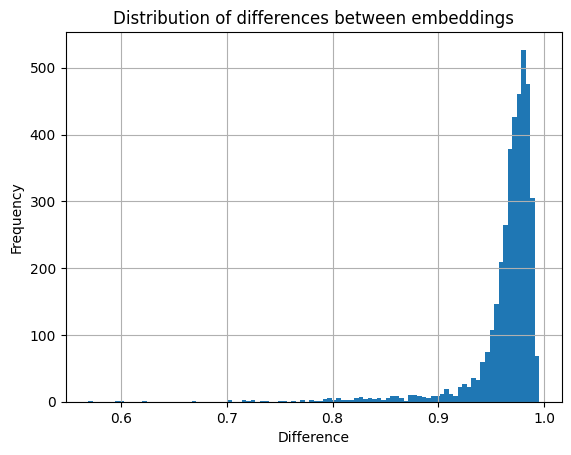

In [6]:
#try to find out whether embeddings differ significantly between posts and claims using MXBAI embeddings:
dataset_claim_embeds['cosine_similarity_post_claim_MXBAI'].hist(bins=100)
plt.title('Distribution of differences between embeddings')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.savefig(f'{CFG.report_dir}/claim_vs_post_embeddings.png')
plt.show()


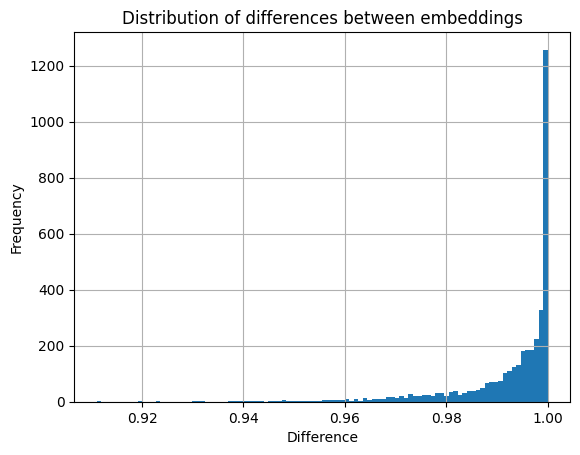

In [14]:
#compare to differences between claims low temperature and claims high temperature:
cosine_low_high_MXBAI = cosine_similarity(dataset_claim_embeds['claim_optdef_embed_MXBAI'].tolist(), dataset_claim_embeds['claim_optlow_MXBAI'].tolist())
dataset_claim_embeds['cosine_low_high_MXBAI'] = cosine_low_high_MXBAI.diagonal()
dataset_claim_embeds['cosine_low_high_MXBAI'].hist(bins=100)
plt.title('Distribution of differences between embeddings')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()


In [ ]:
#compare to differences between post MXBAI and post TF-IDF:
cosine_post_TFIDF_MXBAI = cosine_similarity(dataset_claim_embeds['embed_MXBAI_post'].tolist(), dataset_claim_embeds['tfidf_embed_post'].tolist())
dataset_claim_embeds['cosine_post_TFIDF_MXBAI'] = cosine_post_TFIDF_MXBAI.diagonal()
dataset_claim_embeds['cosine_post_TFIDF_MXBAI'].hist(bins=100)
plt.title('Distribution of differences between embeddings')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()


In [ ]:
#can't be done due to differences in dimensions of the embeddings, use pca to reduce dimensions:
from sklearn.decomposition import TruncatedSVD

def truncated_svd_transform(vector, n_components):
    svd = TruncatedSVD(n_components=n_components)
    return svd.fit_transform([vector])[0]

dataset_claim_embeds['tfidf_embed_post_svd'] = dataset_claim_embeds['tfidf_embed_post'].apply(lambda x: truncated_svd_transform(x, n_components=1024))

comparing these svd embeddings to MXBAI embeddings still fails though...

In [10]:
#try to find out whether we can group comments by source:
print(dataset_claim_embeds['source'].unique())
print(dataset_claim_embeds['showName'].unique())
print(dataset_claim_embeds['videoTitle'].unique())
print(dataset_claim_embeds['in_reply_to_screen_name'].unique())
print(dataset_claim_embeds['channelTitle'].unique())


[None
 '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>'
 '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'
 '<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>'
 '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>'
 '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>'
 '<a href="http://mvilla.it/fenix" rel="nofollow">Fenix 2</a>'
 '<a href="https://www.radioandpodcast.com" rel="nofollow">Malliard to #Malliard</a>'
 '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'
 '<a href="http://www.tweetcaster.com" rel="nofollow">TweetCaster for Android</a>'
 '<a href="http://www.echofon.com/" rel="nofollow">Echofon</a>'
 '<a href="http://tapbots.com/tweetbot" rel="nofollow">Tweetbot for iΟS</a>']
['The 11th Hour' 'Hannity' 'colbertlateshow' 'Fox News'
 'Late Show with Colbert' 'Daily Show' 'ABC Nightline ' 'NBC News'
 'Face

In [12]:
print(dataset_claim_embeds['showName'])
print(dataset_claim_embeds['videoTitle'])
print(dataset_claim_embeds['in_reply_to_screen_name'])
print(dataset_claim_embeds['channelTitle'])

0                            The 11th Hour
1                                  Hannity
2                          colbertlateshow
3                            The 11th Hour
4                            The 11th Hour
                       ...                
3857                       FullFrontalSamB
3858                                 AC360
3859                              ABC News
3860    The Late Show with Stephen Colbert
3861                      CBS Evening News
Name: showName, Length: 3862, dtype: object
0       After Mocking Rubio, President Donald Trump Ha...
1       AOC's chief of staff resigns amid multiple con...
2                                                    None
3       Fmr. Prosecutor On Donald Trump Mocking Kavana...
4       Nicolle Wallace: John McCain In Death Was Able...
                              ...                        
3857                                                 None
3858                                                 None
3859    Assassinati

In [11]:
#showname and videoTitle make most sense to group by:
print(dataset_claim_embeds['showName'].value_counts())
print(dataset_claim_embeds['videoTitle'].value_counts())

showName
NBC News                                201
The Daily Show with Trevor Noah         188
The Late Show with Stephen Colbert      186
Hardball with Chris Matthews            177
Real Time with Bill Maher               172
Hannity                                 171
Tucker Carlson Tonight                  155
Fox News                                152
Late Night with Seth Meyers             148
Face the Nation                         128
60 Minutes                              125
CBS Evening News                        116
ABC News                                109
LastWeekTonight                         106
The 11th Hour                           101
CNN                                      94
Anderson Cooper 360                      89
TuckerCarlson                            82
hardball                                 81
AC360                                    79
Hardball with Chris Matthews (MSNBC)     59
Tucker Carlson Tonight (FoxNews)         58
Full Frontal with Saman

In [22]:
#select the rows in the dataset that have the a showName with more than 100 comments:   
selectedshows = dataset_claim_embeds[dataset_claim_embeds['showName'].isin(dataset_claim_embeds['showName'].value_counts()[dataset_claim_embeds['showName'].value_counts() >= 100].index)]

In [23]:
selectedshows.showName.value_counts()

showName
NBC News                              201
The Daily Show with Trevor Noah       188
The Late Show with Stephen Colbert    186
Hardball with Chris Matthews          177
Real Time with Bill Maher             172
Hannity                               171
Tucker Carlson Tonight                155
Fox News                              152
Late Night with Seth Meyers           148
Face the Nation                       128
60 Minutes                            125
CBS Evening News                      116
ABC News                              109
LastWeekTonight                       106
The 11th Hour                         101
Name: count, dtype: int64

In [14]:
grouped_data = selectedshows.groupby("showName")
dist = torch.nn.PairwiseDistance()
resultstopic: typing.Dict[typing.Tuple[str, str], float] = {}
for model_1, c_1 in tqdm.tqdm(grouped_data['claim_optlow_MXBAI'], total=grouped_data.ngroups):
    for model_2, c_2 in tqdm.tqdm(grouped_data['claim_optlow_MXBAI'], total=grouped_data.ngroups):

        if (
            (model_1, model_2) in resultstopic.keys() or 
            (model_2, model_1) in resultstopic.keys()
        ):
            continue

        res = sum([
            sum(dist(
                torch.tensor(np.array(v_1)), 
                torch.tensor(np.array(c_2.tolist()))
                )) / len(c_2)
            for v_1 in c_1
        ]) / len(c_1)

        resultstopic[(model_1, model_2)] = res

        print(f'{model_1}:{model_2}:{res.item()}')

 13%|█▎        | 2/15 [00:00<00:01, 10.92it/s]

60 Minutes:60 Minutes:6.699946598692885
60 Minutes:ABC News:6.549319579763909
60 Minutes:CBS Evening News:6.623362289152729



 27%|██▋       | 4/15 [00:00<00:01, 10.14it/s]

60 Minutes:Face the Nation:6.589000684984429
60 Minutes:Fox News:6.553924448381198



 47%|████▋     | 7/15 [00:00<00:00,  8.12it/s]

60 Minutes:Hannity:6.567656437591391
60 Minutes:Hardball with Chris Matthews:6.533941577190496



 60%|██████    | 9/15 [00:01<00:00,  8.58it/s]

60 Minutes:LastWeekTonight:6.47099217990759
60 Minutes:Late Night with Seth Meyers:6.401327347354272



 73%|███████▎  | 11/15 [00:01<00:00,  7.60it/s]

60 Minutes:NBC News:6.461630916999484
60 Minutes:Real Time with Bill Maher:6.588453145092005



 87%|████████▋ | 13/15 [00:01<00:00,  7.88it/s]

60 Minutes:The 11th Hour:6.48982317247386
60 Minutes:The Daily Show with Trevor Noah:6.4959834351562105



  7%|▋         | 1/15 [00:01<00:26,  1.86s/it]

60 Minutes:The Late Show with Stephen Colbert:6.422629063336613
60 Minutes:Tucker Carlson Tonight:6.50066205423483



 20%|██        | 3/15 [00:00<00:00, 16.96it/s]

ABC News:ABC News:6.2195879212516765
ABC News:CBS Evening News:6.4063730363364595
ABC News:Face the Nation:6.414296737914172



 33%|███▎      | 5/15 [00:00<00:00, 12.51it/s]

ABC News:Fox News:6.380807895598997
ABC News:Hannity:6.379816875529999



 60%|██████    | 9/15 [00:00<00:00, 10.29it/s]

ABC News:Hardball with Chris Matthews:6.380469035453538
ABC News:LastWeekTonight:6.237530736835464
ABC News:Late Night with Seth Meyers:6.201791050272182



 73%|███████▎  | 11/15 [00:01<00:00,  9.13it/s]

ABC News:NBC News:6.2448033655784965
ABC News:Real Time with Bill Maher:6.398878835252548



 87%|████████▋ | 13/15 [00:01<00:00,  9.07it/s]

ABC News:The 11th Hour:6.317485681019367
ABC News:The Daily Show with Trevor Noah:6.282352443298999



 13%|█▎        | 2/15 [00:03<00:21,  1.69s/it]

ABC News:The Late Show with Stephen Colbert:6.2051469937436705
ABC News:Tucker Carlson Tonight:6.305092850611651



 27%|██▋       | 4/15 [00:00<00:00, 21.45it/s]

CBS Evening News:CBS Evening News:6.348578764251924
CBS Evening News:Face the Nation:6.403009185321105
CBS Evening News:Fox News:6.36933235357251
CBS Evening News:Hannity:6.374377465473281



 47%|████▋     | 7/15 [00:00<00:00, 11.20it/s]

CBS Evening News:Hardball with Chris Matthews:6.358857702782433
CBS Evening News:LastWeekTonight:6.3273110335979466



 60%|██████    | 9/15 [00:00<00:00, 10.43it/s]

CBS Evening News:Late Night with Seth Meyers:6.25908800543423
CBS Evening News:NBC News:6.28086396096831



 73%|███████▎  | 11/15 [00:01<00:00,  9.04it/s]

CBS Evening News:Real Time with Bill Maher:6.4310086826956665
CBS Evening News:The 11th Hour:6.33260039356323



 93%|█████████▎| 14/15 [00:01<00:00,  8.54it/s]

CBS Evening News:The Daily Show with Trevor Noah:6.346909360196532
CBS Evening News:The Late Show with Stephen Colbert:6.278736277014221



 20%|██        | 3/15 [00:05<00:19,  1.64s/it]

CBS Evening News:Tucker Carlson Tonight:6.315227721428547



 27%|██▋       | 4/15 [00:00<00:00, 36.82it/s]

Face the Nation:Face the Nation:6.167854376350992
Face the Nation:Fox News:6.186634445977847
Face the Nation:Hannity:6.234462770538287
Face the Nation:Hardball with Chris Matthews:6.124618642212895



 53%|█████▎    | 8/15 [00:00<00:00, 11.39it/s]

Face the Nation:LastWeekTonight:6.356244197852768
Face the Nation:Late Night with Seth Meyers:6.0834936658728855



 67%|██████▋   | 10/15 [00:00<00:00,  9.53it/s]

Face the Nation:NBC News:6.236679036763175
Face the Nation:Real Time with Bill Maher:6.305479166653474



 80%|████████  | 12/15 [00:01<00:00,  9.18it/s]

Face the Nation:The 11th Hour:6.117328855596019
Face the Nation:The Daily Show with Trevor Noah:6.268308249810536



 93%|█████████▎| 14/15 [00:01<00:00,  8.11it/s]

Face the Nation:The Late Show with Stephen Colbert:6.174776949641233



 27%|██▋       | 4/15 [00:06<00:17,  1.63s/it]

Face the Nation:Tucker Carlson Tonight:6.172835590388605



 33%|███▎      | 5/15 [00:00<00:00, 33.26it/s]

Fox News:Fox News:6.109993843334379
Fox News:Hannity:6.189977196245456
Fox News:Hardball with Chris Matthews:6.100322006222233
Fox News:LastWeekTonight:6.3268642098652395



 60%|██████    | 9/15 [00:00<00:00, 10.53it/s]

Fox News:Late Night with Seth Meyers:6.066768299147256



 73%|███████▎  | 11/15 [00:01<00:00,  8.32it/s]

Fox News:NBC News:6.202840569695053
Fox News:Real Time with Bill Maher:6.277800341251318



 87%|████████▋ | 13/15 [00:01<00:00,  7.84it/s]

Fox News:The 11th Hour:6.066652295184708
Fox News:The Daily Show with Trevor Noah:6.236842690354632



 33%|███▎      | 5/15 [00:08<00:16,  1.68s/it]

Fox News:The Late Show with Stephen Colbert:6.150798960131536
Fox News:Tucker Carlson Tonight:6.130502958024187



 40%|████      | 6/15 [00:00<00:00, 31.60it/s]

Hannity:Hannity:6.190097044546794
Hannity:Hardball with Chris Matthews:6.154932829371362
Hannity:LastWeekTonight:6.331090562295479
Hannity:Late Night with Seth Meyers:6.111573170093029



 67%|██████▋   | 10/15 [00:00<00:00,  9.76it/s]

Hannity:NBC News:6.223618791532965
Hannity:Real Time with Bill Maher:6.311944211970443



 80%|████████  | 12/15 [00:01<00:00,  8.59it/s]

Hannity:The 11th Hour:6.124372275363518
Hannity:The Daily Show with Trevor Noah:6.266290392744368



 40%|████      | 6/15 [00:10<00:15,  1.73s/it]

Hannity:The Late Show with Stephen Colbert:6.1837879928818955
Hannity:Tucker Carlson Tonight:6.169378977559263



 47%|████▋     | 7/15 [00:00<00:00, 33.64it/s]

Hardball with Chris Matthews:Hardball with Chris Matthews:5.989572626779053
Hardball with Chris Matthews:LastWeekTonight:6.329946024914842
Hardball with Chris Matthews:Late Night with Seth Meyers:6.005685585585151



 73%|███████▎  | 11/15 [00:00<00:00, 10.20it/s]

Hardball with Chris Matthews:NBC News:6.181771467998242
Hardball with Chris Matthews:Real Time with Bill Maher:6.238137732510912
Hardball with Chris Matthews:The 11th Hour:6.009412947880339



 87%|████████▋ | 13/15 [00:01<00:00,  8.66it/s]

Hardball with Chris Matthews:The Daily Show with Trevor Noah:6.206652512063726



 47%|████▋     | 7/15 [00:11<00:13,  1.72s/it]

Hardball with Chris Matthews:The Late Show with Stephen Colbert:6.107964266518964
Hardball with Chris Matthews:Tucker Carlson Tonight:6.10003174718449



 60%|██████    | 9/15 [00:00<00:00, 50.77it/s]

LastWeekTonight:LastWeekTonight:5.965610164057077
LastWeekTonight:Late Night with Seth Meyers:6.106066497247096
LastWeekTonight:NBC News:6.153020485600537
LastWeekTonight:Real Time with Bill Maher:6.3103949312379095
LastWeekTonight:The 11th Hour:6.272723895890553
LastWeekTonight:The Daily Show with Trevor Noah:6.186095643121395
LastWeekTonight:The Late Show with Stephen Colbert:6.090688326501274



 53%|█████▎    | 8/15 [00:12<00:10,  1.45s/it]

LastWeekTonight:Tucker Carlson Tonight:6.250244194345567



 60%|██████    | 9/15 [00:00<00:00, 63.68it/s]

Late Night with Seth Meyers:Late Night with Seth Meyers:5.852580516843409
Late Night with Seth Meyers:NBC News:6.0534647528516485
Late Night with Seth Meyers:Real Time with Bill Maher:6.133647815945153
Late Night with Seth Meyers:The 11th Hour:5.982819357531834
Late Night with Seth Meyers:The Daily Show with Trevor Noah:6.066113066897822
Late Night with Seth Meyers:The Late Show with Stephen Colbert:5.955971758035118


 60%|██████    | 9/15 [00:13<00:08,  1.35s/it]

Late Night with Seth Meyers:Tucker Carlson Tonight:6.037102015861383



 67%|██████▋   | 10/15 [00:00<00:00, 39.02it/s]

NBC News:NBC News:6.1002176756911535
NBC News:Real Time with Bill Maher:6.253853005869702
NBC News:The 11th Hour:6.146676253186102
NBC News:The Daily Show with Trevor Noah:6.166812216461162



 93%|█████████▎| 14/15 [00:01<00:00, 10.43it/s]

NBC News:The Late Show with Stephen Colbert:6.084216852018901


 67%|██████▋   | 10/15 [00:15<00:06,  1.35s/it]

NBC News:Tucker Carlson Tonight:6.1520449662193055



  0%|          | 0/15 [00:00<?, ?it/s]


Real Time with Bill Maher:Real Time with Bill Maher:6.318750176538892


 73%|███████▎  | 11/15 [00:00<00:00, 57.03it/s]

Real Time with Bill Maher:The 11th Hour:6.211579681939899
Real Time with Bill Maher:The Daily Show with Trevor Noah:6.286455853512634


 73%|███████▎  | 11/15 [00:16<00:04,  1.22s/it]

Real Time with Bill Maher:The Late Show with Stephen Colbert:6.194738461114224
Real Time with Bill Maher:Tucker Carlson Tonight:6.242984349138239



  0%|          | 0/15 [00:00<?, ?it/s]

The 11th Hour:The 11th Hour:5.8971207297941675



 87%|████████▋ | 13/15 [00:00<00:00, 33.50it/s]

The 11th Hour:The Daily Show with Trevor Noah:6.177883661573091
The 11th Hour:The Late Show with Stephen Colbert:6.070393504853004


 80%|████████  | 12/15 [00:16<00:03,  1.04s/it]

The 11th Hour:Tucker Carlson Tonight:6.067526528277279



 87%|████████▋ | 13/15 [00:00<00:00, 57.62it/s]

The Daily Show with Trevor Noah:The Daily Show with Trevor Noah:6.162680646239894


 87%|████████▋ | 13/15 [00:17<00:01,  1.09it/s]

The Daily Show with Trevor Noah:The Late Show with Stephen Colbert:6.104607541319869
The Daily Show with Trevor Noah:Tucker Carlson Tonight:6.19589153073852



 93%|█████████▎| 14/15 [00:17<00:00,  1.30it/s]

The Late Show with Stephen Colbert:The Late Show with Stephen Colbert:5.974502913617009
The Late Show with Stephen Colbert:Tucker Carlson Tonight:6.111457572700038



100%|██████████| 15/15 [00:18<00:00,  1.21s/it]

Tucker Carlson Tonight:Tucker Carlson Tonight:6.06691014805205


In [19]:
#select the rows in the dataset that have the a videoTitle with more than 20 comments:   
selectedvideos = dataset_claim_embeds[dataset_claim_embeds['videoTitle'].isin(dataset_claim_embeds['videoTitle'].value_counts()[dataset_claim_embeds['videoTitle'].value_counts() >= 20].index)]

In [20]:
selectedvideos.videoTitle.value_counts()

videoTitle
Anderson Cooper lays out questions surrounding Mueller report                        23
'Hannity' panel on the important questions Mueller needs to answer                   23
Sanders: Bolton is a guy who likes war                                               22
AOC's chief of staff resigns amid multiple controversies                             20
'Duck Dynasty' stars on dangers of the 'liberal left'                                20
Hannity: Trump puts Iran on notice after drone shot down                             20
Monologue: Trump's "Got Away with Treason" Tour | Real Time with Bill Maher (HBO)    20
Teacher who said she was fired over topless selfie says she 'lost everything'        20
Trump talks race, football, foreign policy and more ahead of the Super Bowl          20
"Haley: Airstrikes ""crippled"" Syria’s chemical weapons program  "                  20
John Berman: Is it even news when the President lies?                                20
Trump: US, France and

In [21]:
grouped_data = selectedvideos.groupby("videoTitle")
dist = torch.nn.PairwiseDistance()
resultstopic: typing.Dict[typing.Tuple[str, str], float] = {}
for model_1, c_1 in tqdm.tqdm(grouped_data['claim_optlow_MXBAI'], total=grouped_data.ngroups):
    for model_2, c_2 in tqdm.tqdm(grouped_data['claim_optlow_MXBAI'], total=grouped_data.ngroups):

        if (
            (model_1, model_2) in resultstopic.keys() or 
            (model_2, model_1) in resultstopic.keys()
        ):
            continue

        res = sum([
            sum(dist(
                torch.tensor(np.array(v_1)), 
                torch.tensor(np.array(c_2.tolist()))
                )) / len(c_2)
            for v_1 in c_1
        ]) / len(c_1)

        resultstopic[(model_1, model_2)] = res

        print(f'{model_1}:{model_2}:{res.item()}')

100%|██████████| 13/13 [00:00<00:00, 271.79it/s]


"Haley: Airstrikes ""crippled"" Syria’s chemical weapons program  ":"Haley: Airstrikes ""crippled"" Syria’s chemical weapons program  ":5.507587212302954
"Haley: Airstrikes ""crippled"" Syria’s chemical weapons program  ":'Duck Dynasty' stars on dangers of the 'liberal left':6.6593553970305255
"Haley: Airstrikes ""crippled"" Syria’s chemical weapons program  ":'Hannity' panel on the important questions Mueller needs to answer:6.30640356431548
"Haley: Airstrikes ""crippled"" Syria’s chemical weapons program  ":AOC's chief of staff resigns amid multiple controversies:5.990400713169619
"Haley: Airstrikes ""crippled"" Syria’s chemical weapons program  ":Anderson Cooper lays out questions surrounding Mueller report:5.889747964556231
"Haley: Airstrikes ""crippled"" Syria’s chemical weapons program  ":Hannity: Trump puts Iran on notice after drone shot down:6.2360586797670745
"Haley: Airstrikes ""crippled"" Syria’s chemical weapons program  ":John Berman: Is it even news when the President li


100%|██████████| 13/13 [00:00<00:00, 287.06it/s]


'Duck Dynasty' stars on dangers of the 'liberal left':'Duck Dynasty' stars on dangers of the 'liberal left':6.2181070314796925
'Duck Dynasty' stars on dangers of the 'liberal left':'Hannity' panel on the important questions Mueller needs to answer:6.624843075544652
'Duck Dynasty' stars on dangers of the 'liberal left':AOC's chief of staff resigns amid multiple controversies:6.418154471733319
'Duck Dynasty' stars on dangers of the 'liberal left':Anderson Cooper lays out questions surrounding Mueller report:6.280648226672438
'Duck Dynasty' stars on dangers of the 'liberal left':Hannity: Trump puts Iran on notice after drone shot down:6.882039431676444
'Duck Dynasty' stars on dangers of the 'liberal left':John Berman: Is it even news when the President lies?:6.313817184930936
'Duck Dynasty' stars on dangers of the 'liberal left':Monologue: Trump's "Got Away with Treason" Tour | Real Time with Bill Maher (HBO):6.369269571164606
'Duck Dynasty' stars on dangers of the 'liberal left':Sanders:


 23%|██▎       | 3/13 [00:00<00:00, 20.39it/s]

'Hannity' panel on the important questions Mueller needs to answer:'Hannity' panel on the important questions Mueller needs to answer:5.9050547989597115
'Hannity' panel on the important questions Mueller needs to answer:AOC's chief of staff resigns amid multiple controversies:5.921784692324922
'Hannity' panel on the important questions Mueller needs to answer:Anderson Cooper lays out questions surrounding Mueller report:5.784096417744665
'Hannity' panel on the important questions Mueller needs to answer:Hannity: Trump puts Iran on notice after drone shot down:6.385437385710106
'Hannity' panel on the important questions Mueller needs to answer:John Berman: Is it even news when the President lies?:5.694389962015134
'Hannity' panel on the important questions Mueller needs to answer:Monologue: Trump's "Got Away with Treason" Tour | Real Time with Bill Maher (HBO):5.891511636101881
'Hannity' panel on the important questions Mueller needs to answer:Sanders: Bolton is a guy who likes war:6.31


100%|██████████| 13/13 [00:00<00:00, 363.83it/s]


AOC's chief of staff resigns amid multiple controversies:AOC's chief of staff resigns amid multiple controversies:5.3845631436046
AOC's chief of staff resigns amid multiple controversies:Anderson Cooper lays out questions surrounding Mueller report:5.592954584086895
AOC's chief of staff resigns amid multiple controversies:Hannity: Trump puts Iran on notice after drone shot down:6.126327857577474
AOC's chief of staff resigns amid multiple controversies:John Berman: Is it even news when the President lies?:5.43802816319102
AOC's chief of staff resigns amid multiple controversies:Monologue: Trump's "Got Away with Treason" Tour | Real Time with Bill Maher (HBO):5.661561195448241
AOC's chief of staff resigns amid multiple controversies:Sanders: Bolton is a guy who likes war:6.036138703054792
AOC's chief of staff resigns amid multiple controversies:Source: Trump attended 2015 hush money meeting:5.7045861918613205
AOC's chief of staff resigns amid multiple controversies:Teacher who said she w


  0%|          | 0/13 [00:00<?, ?it/s]

Anderson Cooper lays out questions surrounding Mueller report:Anderson Cooper lays out questions surrounding Mueller report:5.0361208058139475
Anderson Cooper lays out questions surrounding Mueller report:Hannity: Trump puts Iran on notice after drone shot down:6.062048666946851
Anderson Cooper lays out questions surrounding Mueller report:John Berman: Is it even news when the President lies?:5.165187785587677
Anderson Cooper lays out questions surrounding Mueller report:Monologue: Trump's "Got Away with Treason" Tour | Real Time with Bill Maher (HBO):5.517039234469161


100%|██████████| 13/13 [00:00<00:00, 340.92it/s]


Anderson Cooper lays out questions surrounding Mueller report:Sanders: Bolton is a guy who likes war:5.969532567882393
Anderson Cooper lays out questions surrounding Mueller report:Source: Trump attended 2015 hush money meeting:5.5436449620044534
Anderson Cooper lays out questions surrounding Mueller report:Teacher who said she was fired over topless selfie says she 'lost everything':6.184007964449741
Anderson Cooper lays out questions surrounding Mueller report:Trump talks race, football, foreign policy and more ahead of the Super Bowl:5.547957497724658
Anderson Cooper lays out questions surrounding Mueller report:Trump: US, France and UK launch strikes on Syria:5.7750179316480486



  0%|          | 0/13 [00:00<?, ?it/s]

Hannity: Trump puts Iran on notice after drone shot down:Hannity: Trump puts Iran on notice after drone shot down:6.044318600383173
Hannity: Trump puts Iran on notice after drone shot down:John Berman: Is it even news when the President lies?:5.8998398003745445
Hannity: Trump puts Iran on notice after drone shot down:Monologue: Trump's "Got Away with Treason" Tour | Real Time with Bill Maher (HBO):6.14553678192052
Hannity: Trump puts Iran on notice after drone shot down:Sanders: Bolton is a guy who likes war:6.34613831502392
Hannity: Trump puts Iran on notice after drone shot down:Source: Trump attended 2015 hush money meeting:6.211632376931067
Hannity: Trump puts Iran on notice after drone shot down:Teacher who said she was fired over topless selfie says she 'lost everything':6.945918808004881
Hannity: Trump puts Iran on notice after drone shot down:Trump talks race, football, foreign policy and more ahead of the Super Bowl:6.163429775209616


 46%|████▌     | 6/13 [00:00<00:00, 23.81it/s]

Hannity: Trump puts Iran on notice after drone shot down:Trump: US, France and UK launch strikes on Syria:6.443570562407369



100%|██████████| 13/13 [00:00<00:00, 520.36it/s]


John Berman: Is it even news when the President lies?:John Berman: Is it even news when the President lies?:4.684106252965498
John Berman: Is it even news when the President lies?:Monologue: Trump's "Got Away with Treason" Tour | Real Time with Bill Maher (HBO):5.33071456616141
John Berman: Is it even news when the President lies?:Sanders: Bolton is a guy who likes war:5.845374036752955
John Berman: Is it even news when the President lies?:Source: Trump attended 2015 hush money meeting:5.369528692549277
John Berman: Is it even news when the President lies?:Teacher who said she was fired over topless selfie says she 'lost everything':6.255946394116749
John Berman: Is it even news when the President lies?:Trump talks race, football, foreign policy and more ahead of the Super Bowl:5.435187812538009
John Berman: Is it even news when the President lies?:Trump: US, France and UK launch strikes on Syria:5.80540257832684



  0%|          | 0/13 [00:00<?, ?it/s]

Monologue: Trump's "Got Away with Treason" Tour | Real Time with Bill Maher (HBO):Monologue: Trump's "Got Away with Treason" Tour | Real Time with Bill Maher (HBO):5.278842591857321
Monologue: Trump's "Got Away with Treason" Tour | Real Time with Bill Maher (HBO):Sanders: Bolton is a guy who likes war:6.018878696982894
Monologue: Trump's "Got Away with Treason" Tour | Real Time with Bill Maher (HBO):Source: Trump attended 2015 hush money meeting:5.704677591790893
Monologue: Trump's "Got Away with Treason" Tour | Real Time with Bill Maher (HBO):Teacher who said she was fired over topless selfie says she 'lost everything':6.33609570632735


100%|██████████| 13/13 [00:00<00:00, 579.33it/s]


Monologue: Trump's "Got Away with Treason" Tour | Real Time with Bill Maher (HBO):Trump talks race, football, foreign policy and more ahead of the Super Bowl:5.600608716055669
Monologue: Trump's "Got Away with Treason" Tour | Real Time with Bill Maher (HBO):Trump: US, France and UK launch strikes on Syria:5.814774626063519



100%|██████████| 13/13 [00:00<00:00, 658.44it/s]


Sanders: Bolton is a guy who likes war:Sanders: Bolton is a guy who likes war:5.948851404228827
Sanders: Bolton is a guy who likes war:Source: Trump attended 2015 hush money meeting:6.121279288939343
Sanders: Bolton is a guy who likes war:Teacher who said she was fired over topless selfie says she 'lost everything':6.769637777534063
Sanders: Bolton is a guy who likes war:Trump talks race, football, foreign policy and more ahead of the Super Bowl:6.0803442136291315
Sanders: Bolton is a guy who likes war:Trump: US, France and UK launch strikes on Syria:6.238429399471386



100%|██████████| 13/13 [00:00<00:00, 884.63it/s]


Source: Trump attended 2015 hush money meeting:Source: Trump attended 2015 hush money meeting:5.481919618026874
Source: Trump attended 2015 hush money meeting:Teacher who said she was fired over topless selfie says she 'lost everything':6.399491769895586
Source: Trump attended 2015 hush money meeting:Trump talks race, football, foreign policy and more ahead of the Super Bowl:5.81730271318534
Source: Trump attended 2015 hush money meeting:Trump: US, France and UK launch strikes on Syria:6.059340417205097



 85%|████████▍ | 11/13 [00:00<00:00, 33.59it/s]

Teacher who said she was fired over topless selfie says she 'lost everything':Teacher who said she was fired over topless selfie says she 'lost everything':5.73652882795008
Teacher who said she was fired over topless selfie says she 'lost everything':Trump talks race, football, foreign policy and more ahead of the Super Bowl:6.367238435455738
Teacher who said she was fired over topless selfie says she 'lost everything':Trump: US, France and UK launch strikes on Syria:6.164541887853593



100%|██████████| 13/13 [00:00<00:00, 1710.99it/s]


Trump talks race, football, foreign policy and more ahead of the Super Bowl:Trump talks race, football, foreign policy and more ahead of the Super Bowl:5.363053949546176
Trump talks race, football, foreign policy and more ahead of the Super Bowl:Trump: US, France and UK launch strikes on Syria:5.856155241849135



100%|██████████| 13/13 [00:00<00:00, 34.20it/s]

Trump: US, France and UK launch strikes on Syria:Trump: US, France and UK launch strikes on Syria:5.302273179853221


In [24]:
#so what do the most and least diverse video threads look like?
#lowest: John Berman: Is it even news when the President lies?:John Berman: Is it even news when the President lies?:4.684106252965498
#highest: 'Duck Dynasty' stars on dangers of the 'liberal left':'Duck Dynasty' stars on dangers of the 'liberal left':6.2181070314796925

In [27]:
selectedvideos.loc[selectedvideos.videoTitle=='John Berman: Is it even news when the President lies?', :]['commentText'].to_list()

['Chuck the schmuck Schumer, a creep all day long, news all day long!!! And Nancy pa crazy,!! She looks like the Crypt Keeper!!',
 "That's all TRUMP DOES, is LIE!",
 "@Trump's a pathological liar Prove me wrong < Mmmmm. Are you stupid because you're liberal or are you liberal because you're stupid?",
 'So you want to talk about lies?? LMAO. "OOOK" you attack his poor grasp of communication and exploit it. Meanwhile causing ACTUAL divide and real problems with BIG lies.... Trying to get us to care and take notice about some pointless Symantecs. You created more hate and violence in leftist fenatisicm by insisting he is some evil racist, than he ever did trying do promote boarder security.... Hes a bit of a fuk up ih a few ways for sure....but nothing on the mass scale of manipulation and social division that you and the rest of the George Orwell, erm i mean Soros media, have brought to fruition.',
 'Is it News if CNN reports it???',
 "@David tinch No. Like I said in three original comme

In [33]:
selectedvideos.loc[selectedvideos.videoTitle=="'Duck Dynasty' stars on dangers of the 'liberal left'", :]['commentText'].to_list()

['Duck Dynasty?! Seriously, Hannity? No wonder youâ€™re Trumpy the unexonerated clownâ€™s concubine. You have such a low bar. \nðŸ¤£ðŸ¤£ What a moron.',
 'religion and the belief in "god" is whats wrong with this country',
 'Knowing that there are still God fearing men (and women) like this out there is comforting. There is still hope.',
 'OMG!! So true! So refreshing! ❤ Jesus!',
 'I just love Phil. He tells ya like it is.',
 'Mike Jameson Oh there is a God the one true God and you will be held accountable when your time comes. Seek Jesus he is waiting for you with open arms I love you my friend God Bless you.',
 "Love the Robertsons. I miss them. It's like not seeing a family member for a really long time.",
 'Okay but am I the only one that thinks Al looks like Alex Jones.',
 'I can tolerate Ignorance.\nI can tolerate Arrogance.\nBut put both together and you have a typical Democrat.\nThey seem to be suffering from a Mental Illness called Cognitive Dissonance.\nThat means they simply

In [ ]:
#I can't see any difference in the comments, except for the large degree of arguing and uncivil speech in both threads, no clear explanation stands out why the diversity in the embeddings is so different.....
